# SNOTEL combo plot
---
Plot snow disappearance dates of input datasets against corresponding SNOTEL dates.  
Abbreviated bar plot.  

*J. Michelle Hu  
University of Utah  
May 2025* 

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import PurePath

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [2]:
import seaborn as sns
cmap = sns.color_palette('icefire')
cmap

[(0.33355526, 0.64107876, 0.80445484),
 (0.28708711, 0.32912157, 0.69034504),
 (0.15652427, 0.15348248, 0.22238175),
 (0.22994394, 0.13076731, 0.15146314),
 (0.61319563, 0.1824336, 0.2687872),
 (0.91463791, 0.43668557, 0.21367954)]

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from typing import List

In [5]:
def locate_snotel_extracts(basins: List[str], WYs: List[int], modeldir: str) -> List[str]:
    """
    Locate the SNOTEL extracts for the given basins and water years.
    Parameters
    ----------
    basins : list of str
        List of basin names to locate SNOTEL extracts for.
    WYs : list of int
        List of water years to locate SNOTEL extracts for.
    Returns
    -------
    list of str
        List of file paths to the SNOTEL extracts.
    """
    # Match selected basin and allowed water year
    isnobal_csvs = [h.fn_list(modeldir, f'{basin}*/wy{WY}/{basin}*thickness_snotelmetloom*.csv') for basin in basins for WY in WYs]
    # Flatten into a single list
    isnobal_csvs = [item for sublist in isnobal_csvs for item in sublist]
    return isnobal_csvs
# Thickness SNOTEL data is in each wydir as yampa_HRRR-MODIS_thickness_snotelmetloom_wy2021.csv oryampa_iSnobal-HRRR_thickness_snotelmetloom_wy2021.csv
# TODO: Need to update the HRRR-MODIS to HRRR-SPIReS in the extract code (separate from this)
basins = ['blue', 'animas', 'yampa']
WYs = [2021, 2022, 2023, 2024]
modeldir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs'

isnobal_csvs = locate_snotel_extracts(basins=basins, WYs=WYs, modeldir=modeldir)
isnobal_csvs

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2021/blue_HRRR-MODIS_thickness_snotelmetloom_wy2021.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2021/blue_iSnobal-HRRR_thickness_snotelmetloom_wy2021.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2022/blue_HRRR-MODIS_thickness_snotelmetloom_wy2022.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2022/blue_iSnobal-HRRR_thickness_snotelmetloom_wy2022.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2023/blue_HRRR-MODIS_thickness_snotelmetloom_wy2023.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2023/blue_iSnobal-HRRR_thickness_snotelmetloom_wy2023.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2024/blue_HRRR-MODIS_thickness_snotelmetloom_wy2024.csv',
 '/uufs/chpc.utah.edu/common/home/s

In [6]:
def extract_sdd(fp: str, compute_doy: bool = True, alg='first', verbose: bool = True):
    # Note basin, implementation, and WY, which you can pull directly from the filename, this will be used for the column names
    basin, run, snowvar, _, WY = PurePath(fp).stem.split('_')
    # Handle run names
    if run == 'HRRR-MODIS':
        run = 'HRRR-SPIReS'
    elif run == 'iSnobal-HRRR':
        run = 'Baseline'
    else:
        raise ValueError(f'Unknown run name: {run}')
    WY = WY.split('wy')[1]
    if verbose:
        print(basin, run, snowvar, WY)

    # Load the data for this file
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    # Extract SNOTEL sitenames from columns
    sitenames = df.columns
    # Reformat into file-compatible column names
    sitenames = [s.replace(' ', '').replace('-', '_').replace('#', '').replace('(', '_').replace(')', '') for s in sitenames]

    df_fullnames = [f'{basin}_{run}_{WY}_{site}' for site in sitenames]
    df_rownames = [f'{basin}_{site}' for site in sitenames]
    df_colname = f'{run}_wy{WY}'
    # Compute the SDD for each series and only grab the timestamp, not the full series
    sdd_list = [proc.calc_sdd(snow_property=df[dfcol], alg=alg, verbose=False)[0] for dfcol in df.columns]
    if verbose:
        print(sdd_list)

    if compute_doy:
        # Convert these timestamps to just that day of year (cut off the hours)
        doy_sdd_list = [ts.dayofyear for ts in sdd_list]
        if verbose:
            print(doy_sdd_list)

    return df_colname, df_rownames, df_fullnames, sitenames, sdd_list

In [7]:
def construct_sdd_df(isnobal_csvs):
    # Load data calculated SDD and store in dict
    sdd_dict = dict()
    for fp in isnobal_csvs:
        df_colname, df_rownames, df_fullnames, sitenames, sdd_list = extract_sdd(fp=fp, compute_doy=False, verbose=False)
        sdd_dict[PurePath(fp).stem] = df_colname, df_rownames, df_fullnames, sdd_list

    # # Value for first key in dict
    # sdd_dict[list(sdd_dict.keys())[0]]

    # Extract relevant data from the dict to construt a dataframe
    colnames = [sdd_dict[k][0] for k in list(sdd_dict.keys())]
    # Remove duplicates by using dict.fromkeys to preserve order (set will yield re-ordering)
    colnames = list(dict.fromkeys(colnames))

    # Generate an index column using basin and sitename (WY and run are already in the column names)
    index_col = [sdd_dict[k][1] for k in list(sdd_dict.keys())]
    # Flatten into a single list
    index_col = h.flatten(index_col)
    # Remove duplicates by using dict.fromkeys to preserve order (set will yield re-ordering)
    index_col = list(dict.fromkeys(index_col))

    # Construct a dataframe of the sdd lists from the dict
    # Pull directly, this should generate each row with the basin_run's snotel site sdds
    # The number of columns should be equal to the number of sites in each basin
    sdd_val_df = pd.DataFrame([sdd_dict[k][3] for k in list(sdd_dict.keys())])
    # Transpose this so the rows are now the number of sites in each basin
    sdd_val_df = sdd_val_df.T

    # now restack for the columns to follow the run_wy, of which there are 8 in all
    # For every 8 columns, extract and stack as new rows into new big dataframe
    for i in range(0, len(sdd_val_df.columns), len(colnames)):
        # get this slice
        df_slice = sdd_val_df.iloc[:, i:i + len(colnames)]
        # Drop the NaT rows
        df_slice = df_slice.dropna()
        # Specify the colnames for easier merging
        df_slice.columns = colnames
        # Append to a new dataframe
        if i == 0:
            big_sdd_val_df = df_slice
        else:
            big_sdd_val_df = pd.concat([big_sdd_val_df, df_slice], axis=0)
        print(big_sdd_val_df.shape)
    # Drop and reset index in place
    big_sdd_val_df = big_sdd_val_df.reset_index(drop=True)

    # Construct a large dataframe for each basin with SNOTEL sites as index rows and water year and implementation as columns
    # For a total of X snotel site rows by 8 water-year-implementation columns
    big_sdd_df = pd.DataFrame(data=big_sdd_val_df.values, index=index_col, columns=colnames)
    print(big_sdd_df.shape)
    return big_sdd_df

big_sdd_df = construct_sdd_df(isnobal_csvs=isnobal_csvs)

# Convert the whole thing to day of year
big_sdd_df_doy = big_sdd_df.map(lambda x: x.dayofyear if isinstance(x, pd.Timestamp) else x)
big_sdd_df_doy

(4, 8)
(9, 8)
(19, 8)
(19, 8)


,HRRR-SPIReS_wy2021,Baseline_wy2021,HRRR-SPIReS_wy2022,Baseline_wy2022,HRRR-SPIReS_wy2023,Baseline_wy2023,HRRR-SPIReS_wy2024,Baseline_wy2024
blue_CopperMountain_415,128,160,135,168,137,171,140,174
blue_FremontPass_485,137,169,138,178,143,184,144,181
blue_GrizzlyPeak_505,156,140,160,154,169,147,169,164
blue_HoosierPass_531,148,175,139,180,136,182,152,185
animas_Cascade2_387,103,123,105,122,122,145,108,135
animas_MineralCreek_629,114,146,105,144,135,169,115,155
animas_MolasLake_632,115,143,126,140,143,163,126,150
animas_RedMountainPass_713,134,165,123,161,149,186,154,171
animas_SpudMountain_780,119,150,123,148,143,179,121,160
yampa_BearRiver_1061,126,161,112,162,123,172,121,173


# Extract corresponding SNOTEL data

In [8]:
def prep_snotel_meta(basin, state_abbrev='CO', buffer=200,
                poly_dir='/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/ancillary/polys',
                site_locs_fn='/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'):
    poly_fn = h.fn_list(poly_dir, f'*{basin}*shp')[0]

    # Locate SNOTEL sites within basin
    found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=site_locs_fn, buffer=buffer)

    # Get site names and site numbers
    sitenames = found_sites['site_name']
    sitenums = found_sites['site_num']
    print(sitenames)
    fixed_names = [site.replace(' ', '').replace('-', '_').replace('#', '').replace('(', '_').replace(')', '') for site in sitenames]
    # prepend basin as well
    fixed_names = [f'{basin}_{site}' for site in fixed_names]
    ST_arr = [state_abbrev] * len(sitenums)
    return sitenames, sitenums, fixed_names, ST_arr

def extract_snotel_sdd(sitenums, sitenames, fixed_names, WYs, ST_arr, epsg=32613, return_df=True, return_meta=False, snowvar='SNOWDEPTH'):
    # Prepare your final dataframe of snotel SDD with WYs as columns and sites as rows
    snotel_basin_df = pd.DataFrame(index=fixed_names, columns=[f'SNOTEL_wy{WY}' for WY in WYs])

    # Get the SNOTEL data for all input water years so this only happens once
    _, snotel_dfs = proc.get_snotel(sitenum=sitenums, sitename=sitenames, WY=WYs, ST=ST_arr, epsg=epsg, return_df=return_df, return_meta=return_meta, snowvar=snowvar)

    # From these snotel_dfs, process to pull out the series of interest
    snotel_dfs_vars = [df[f'{snowvar}_m'] for df in snotel_dfs]

    # Combine this list of SNOTEL dataframes into a single dataframe
    temp_snotel_df = pd.concat(snotel_dfs_vars, axis=1)

    # Rename the columns as the sitenames for this basin
    temp_snotel_df.columns = fixed_names

    for WY in WYs:
        # slice up the dataframe based on datetime
        thisWY_df = temp_snotel_df[(temp_snotel_df.index.date >= pd.to_datetime(f'{WY-1}-10-01').date()) & (temp_snotel_df.index.date <= pd.to_datetime(f'{WY}-09-30').date())]
        # Get the SDD for this WY for each column in this dataframe with a lambda function
        thisWY_sdds = thisWY_df.apply(lambda x: proc.calc_sdd(snow_property=x, alg='first', verbose=False)[0], axis=0)
        snotel_basin_df[f'SNOTEL_wy{WY}'] = thisWY_sdds
    return snotel_basin_df

In [9]:
def construct_snotelsdd_df(basins, WYs, epsg=32613, snowvar='SNOWDEPTH', state_abbrev='CO'):
    big_snotel_df = list()
    for basin in basins:
        sitenames, sitenums, fixed_names, ST_arr = prep_snotel_meta(basin=basin, state_abbrev=state_abbrev)
        snotel_basin_df = extract_snotel_sdd(sitenums=sitenums, sitenames=sitenames, fixed_names=fixed_names, WYs=WYs, ST_arr=ST_arr, epsg=epsg, snowvar=snowvar)
        big_snotel_df.append(snotel_basin_df)

    big_snotel_df = pd.concat(big_snotel_df, axis=0)
    return big_snotel_df

big_snotel_df = construct_snotelsdd_df(basins, WYs)

32613
155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
173       Hoosier Pass (531)
Name: site_name, dtype: object
32613
148           Cascade #2 (387)
199        Mineral Creek (629)
200           Molas Lake (632)
213    Red Mountain Pass (713)
225        Spud Mountain (780)
Name: site_name, dtype: object
32613
136        Bear River (1061)
145       Buffalo Park (913)
156             Crosho (426)
160           Dry Lake (457)
163          Elk River (467)
164    Elkhead Divide (1252)
188           Lost Dog (940)
211        Rabbit Ears (709)
214       Ripple Creek (717)
229              Tower (825)
Name: site_name, dtype: object


In [10]:
big_snotel_df

,SNOTEL_wy2021,SNOTEL_wy2022,SNOTEL_wy2023,SNOTEL_wy2024
blue_CopperMountain_415,2021-05-30 08:00:00+00:00,2022-05-22 08:00:00+00:00,2023-06-07 08:00:00+00:00,2024-06-09 08:00:00+00:00
blue_FremontPass_485,2021-06-11 08:00:00+00:00,2022-06-16 08:00:00+00:00,2023-06-25 08:00:00+00:00,2024-06-24 08:00:00+00:00
blue_GrizzlyPeak_505,2021-06-04 08:00:00+00:00,2022-06-06 08:00:00+00:00,2023-06-10 08:00:00+00:00,2024-06-09 08:00:00+00:00
blue_HoosierPass_531,2021-06-08 08:00:00+00:00,2022-06-08 08:00:00+00:00,2023-06-16 08:00:00+00:00,2024-06-13 08:00:00+00:00
animas_Cascade2_387,2021-04-07 08:00:00+00:00,2022-03-28 08:00:00+00:00,2023-05-02 08:00:00+00:00,2024-04-11 08:00:00+00:00
animas_MineralCreek_629,2021-05-11 08:00:00+00:00,2022-05-02 08:00:00+00:00,2023-05-22 08:00:00+00:00,2024-05-15 08:00:00+00:00
animas_MolasLake_632,2021-05-11 08:00:00+00:00,2022-05-09 08:00:00+00:00,2023-05-31 08:00:00+00:00,2024-05-16 08:00:00+00:00
animas_RedMountainPass_713,2021-06-12 08:00:00+00:00,2022-05-21 08:00:00+00:00,2023-06-21 08:00:00+00:00,2024-06-07 08:00:00+00:00
animas_SpudMountain_780,2021-05-17 08:00:00+00:00,2022-05-10 08:00:00+00:00,2023-06-18 08:00:00+00:00,2024-05-20 08:00:00+00:00
yampa_BearRiver_1061,2021-05-21 08:00:00+00:00,2022-05-12 08:00:00+00:00,2023-05-23 08:00:00+00:00,2024-05-25 08:00:00+00:00


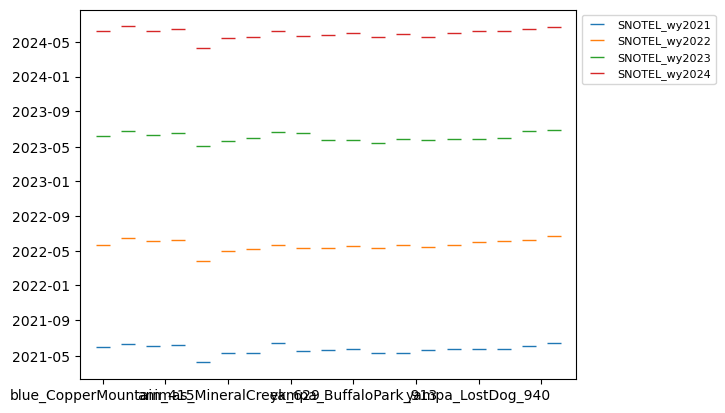

In [11]:
# snotel plot
big_snotel_df.plot(marker='_', markersize=10, linestyle='None')
# put legend on the right, outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

In [12]:
# Compute DOY, which is easier for plotting (could also just pull that out in the doyflag for calc_sdd)
big_snotel_df_doy = big_snotel_df.map(lambda x: x.dayofyear if isinstance(x, pd.Timestamp) else x)
big_snotel_df_doy

,SNOTEL_wy2021,SNOTEL_wy2022,SNOTEL_wy2023,SNOTEL_wy2024
blue_CopperMountain_415,150,142,158,161
blue_FremontPass_485,162,167,176,176
blue_GrizzlyPeak_505,155,157,161,161
blue_HoosierPass_531,159,159,167,165
animas_Cascade2_387,97,87,122,102
animas_MineralCreek_629,131,122,142,136
animas_MolasLake_632,131,129,151,137
animas_RedMountainPass_713,163,141,172,159
animas_SpudMountain_780,137,130,169,141
yampa_BearRiver_1061,141,132,143,146


In [13]:
def make_combo_df(df_list):
    # Construct a large dataframe for each basin with SNOTEL sites as index rows and water year and implementation as columns
    combo_df = pd.concat(df_list, axis=1)

    # Rearrange columns by WY for ease of comparison in dataframe format, e.g., HRRR-SPIReS_wy2021, Baseline_wy2021, SNOTEL_wy2021, etc.
    colnames = list(combo_df.columns)
    print(colnames)
    # Place the SNOTEL_wyYYYY columns after the corresponding HRRR-SPIReS and Baseline columns
    rearranged_colnames = []
    for WY in WYs:
        wy_colnames = [col for col in colnames if f'wy{WY}' in col]
        # Move SNOTEL to the beginning of the list, then Baseline, then HRRR-SPIReS
        wy_colnames = [col for col in wy_colnames if 'SNOTEL' in col] + [col for col in wy_colnames if 'Baseline' in col] + [col for col in wy_colnames if 'HRRR' in col]
        # Use plus equals to not have to flatten the list
        rearranged_colnames += (wy_colnames)
    print(rearranged_colnames)
    # now rearrange the dataframe columns of the combo fig
    combo_df = combo_df[rearranged_colnames]
    return combo_df

combo_df = make_combo_df([big_snotel_df_doy, big_sdd_df_doy])

['SNOTEL_wy2021', 'SNOTEL_wy2022', 'SNOTEL_wy2023', 'SNOTEL_wy2024', 'HRRR-SPIReS_wy2021', 'Baseline_wy2021', 'HRRR-SPIReS_wy2022', 'Baseline_wy2022', 'HRRR-SPIReS_wy2023', 'Baseline_wy2023', 'HRRR-SPIReS_wy2024', 'Baseline_wy2024']
['SNOTEL_wy2021', 'Baseline_wy2021', 'HRRR-SPIReS_wy2021', 'SNOTEL_wy2022', 'Baseline_wy2022', 'HRRR-SPIReS_wy2022', 'SNOTEL_wy2023', 'Baseline_wy2023', 'HRRR-SPIReS_wy2023', 'SNOTEL_wy2024', 'Baseline_wy2024', 'HRRR-SPIReS_wy2024']


In [14]:
# Get this basin
def get_basin_df(df, basin):
    # # Plot the df for a single basin
    # this_df = combo_df.iloc[:, 0:3]
    thisbasin_df = df.loc[df.index.str.contains(basin)].T
    # Convert to doy
    thisbasin_df = thisbasin_df.map(lambda x: x.dayofyear if isinstance(x, pd.Timestamp) else x)

    return thisbasin_df
thisbasin_df = get_basin_df(combo_df.iloc[:, 0:3], basins[0])
thisbasin_df.T

,SNOTEL_wy2021,Baseline_wy2021,HRRR-SPIReS_wy2021
blue_CopperMountain_415,150,160,128
blue_FremontPass_485,162,169,137
blue_GrizzlyPeak_505,155,140,156
blue_HoosierPass_531,159,175,148


In [15]:
def reorganize_df(df):
    # Set the sitenames as a new column
    df['sitename'] = df.index

    # Create a new index_col
    df['index_col'] = 1

    # and reset the index
    df = df.reset_index(drop=True)

    # Set the index_col as the index
    df = df.set_index('index_col')
    return df

this_run = reorganize_df(thisbasin_df.T)
this_run

,SNOTEL_wy2021,Baseline_wy2021,HRRR-SPIReS_wy2021,sitename
index_col,,,,
1,150,160,128,blue_CopperMountain_415
1,162,169,137,blue_FremontPass_485
1,155,140,156,blue_GrizzlyPeak_505
1,159,175,148,blue_HoosierPass_531


In [16]:
SMALL_SIZE = 14
SMEDIUM_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
BIGGEST_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [17]:
def assess_bar_spacing(stepsize=0.4, spacing=0.1, nruns=3):
    # Get some idea of plotting ytick locs
    ticklist = np.arange(0, len(basins), stepsize)
    for i in range(0, len(basins)):
        basin_tick_start = ticklist[i]
        # Loop through runs
        for r in range(0, nruns):
            tick_cluster = basin_tick_start + spacing * r
            print(tick_cluster)
        print('\n')
assess_bar_spacing()

0.0
0.1
0.2


0.4
0.5
0.6000000000000001


0.8
0.9
1.0




In [18]:
colors = ['darkgrey', cmap[0], cmap[1]]
fontsize = SMALL_SIZE
fontstyle ='italic'
color = 'lightgrey'
fontweight = 'semibold'

barlw = 10 #12
baralpha = 1
markersize = 500 #600
markerlw = 1.75 #2.5

# offset between  the basins
offset = np.arange(0, len(basins), 0.4)
run_spacing = 0.1

# Plot for looking at

1 0 blue
1 1 animas
1 2 yampa
ylims: -0.05 – 1.05
ylims: -0.1 – 1.1


(75.0, 574.0)

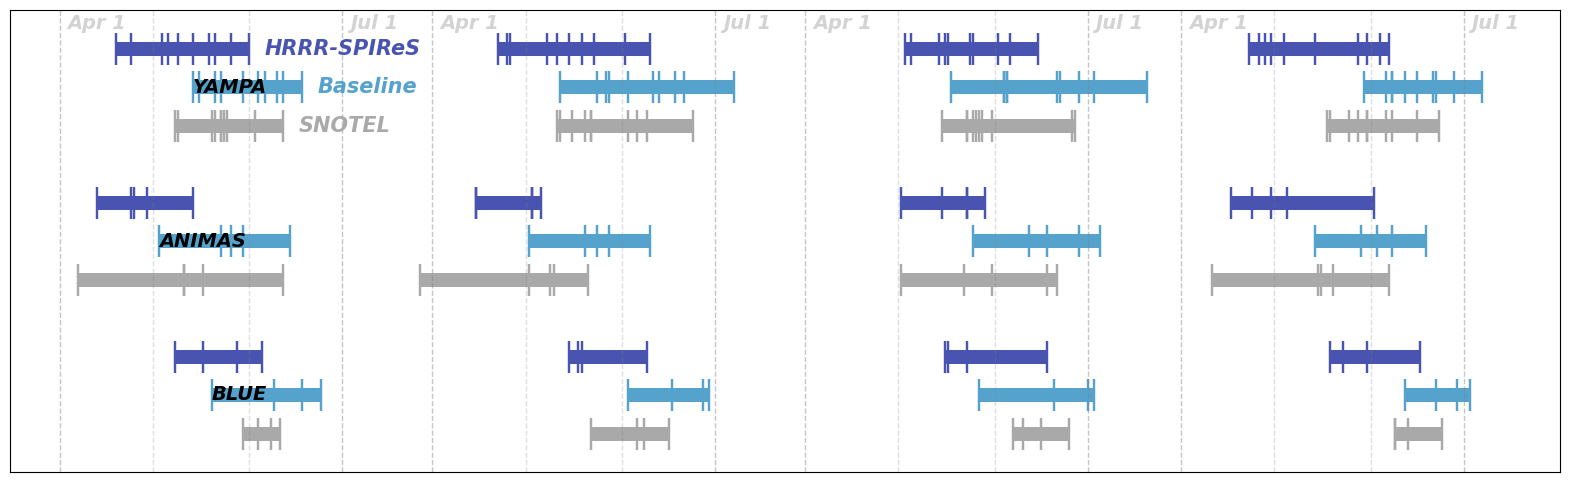

In [19]:
fig, ax = plt.subplots(1, figsize=(20, 6))
# Loop through the water years
for wyoffset, WY in enumerate(WYs):
    start_date = pd.to_datetime(f'{WY}-03-15')
    end_date = pd.to_datetime(f'{WY}-08-01')
    # Go through each basin
    for bdx, basin in enumerate(basins):
        # Pull the basin for this WY
        thisbasin_df = get_basin_df(combo_df.iloc[:, 0 + 3 * wyoffset : 3 + 3 * wyoffset], basin)
        # Reformat the basin df for plotting
        this_run = reorganize_df(thisbasin_df.T)
        # Go through each of the run names
        for idx, col in enumerate(this_run.columns[:-1]):
            y = this_run.index - 1 + offset[bdx] + run_spacing * idx
            # Could try to color according to sitename col
            # adjust x based on the water year, don't do this to scale
            xoffset = 120 * wyoffset
            ax.scatter(x=this_run[col] + xoffset, y=y, marker='|', s=markersize, linewidth=markerlw,
                    color=colors[idx%3], label=col
                    )
            xmin = this_run[col].min() + xoffset
            xmax = this_run[col].max() + xoffset
            ax.hlines(y=y, xmin=xmin, xmax=xmax, color=colors[idx%3], linestyle='-', linewidth=barlw, alpha=baralpha)

            # Annotate these bars for the very topmost set (last basin, first water year)
            if bdx == len(basins)-1 and wyoffset == 0:
                run_xoffset = 5
                ax.annotate(f'{this_run[col].name.split("_")[0]}',
                            xy=(xmax+run_xoffset, y[0]),
                            xytext=(xmax+run_xoffset, y[0]),
                            ha='left', va='center',
                            color=colors[idx],
                            fontweight=fontweight,
                            fontsize=15,
                            fontstyle=fontstyle)
            # Annotate the basin names at xmin, y and idx==1
            if idx == 1 and wyoffset == 0:
                print(idx, bdx, basin)
                ax.annotate(f'{basin.upper()}', xy=(xmin, y[0]), xytext=(xmin, y[0]), ha='left', va='center',
                            color='k',
                            fontweight=fontweight,
                            fontsize=fontsize, fontstyle=fontstyle)
    if (wyoffset == 0) and (bdx == len(basins)-1):
        miny, maxy = ax.get_ylim()
        print(f'ylims: {miny} – {maxy}')
        # Round to floor using tenths place
        miny = np.floor(miny * 10) / 10
        # Round to ceiling and bump up
        maxy = np.ceil(maxy * 10) / 10
        print(f'ylims: {miny} – {maxy}')
    ax.set_ylim(miny, maxy)
    ymax_labels = maxy - 0.05
    # Add vertical lines at the first of each month between april and june and annotate with Month and Day
    for i in range(start_date.month + 1, end_date.month, 1):
        this_month_date = pd.to_datetime(f'{WY}-{i:02d}-01')
        this_month_doy = this_month_date.dayofyear + xoffset
        if (i == 4) or (i == 7):
            ax.vlines(this_month_doy, ymin=miny, ymax=maxy, color='gray', linestyle='--', linewidth=1, alpha=0.45)
        else:
            ax.vlines(this_month_doy, ymin=miny, ymax=maxy, color='gray', linestyle='--', linewidth=1, alpha=0.25)
        if (i == 4) or (i == 7):
            ax.annotate(f'{this_month_date.month_name()[:3]} 1', xy=(this_month_doy+run_xoffset/2, ymax_labels), xytext=(this_month_doy+run_xoffset/2, ymax_labels),
                        color=color,
                        fontweight=fontweight,
                        fontsize=fontsize, fontstyle=fontstyle)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(start_date.dayofyear, end_date.dayofyear + xoffset)

# Plot for poster

ylims: -0.05 – 1.05
ylims: -0.1 – 1.1


(75.0, 574.0)

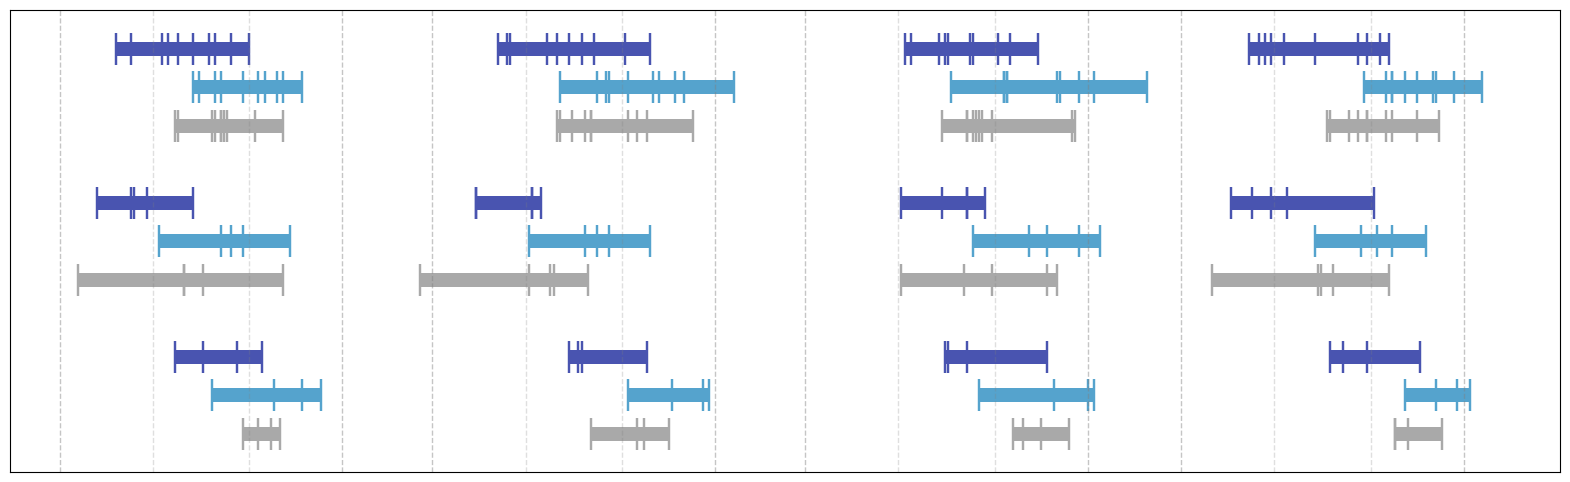

In [20]:
fig, ax = plt.subplots(1, figsize=(20, 6))
# Loop through the water years
for wyoffset, WY in enumerate(WYs):
    start_date = pd.to_datetime(f'{WY}-03-15')
    end_date = pd.to_datetime(f'{WY}-08-01')
    # Go through each basin
    for bdx, basin in enumerate(basins):
        # Pull the basin for this WY
        thisbasin_df = get_basin_df(combo_df.iloc[:, 0 + 3 * wyoffset : 3 + 3 * wyoffset], basin)
        # Reformat the basin df for plotting
        this_run = reorganize_df(thisbasin_df.T)
        # Go through each of the run names
        for idx, col in enumerate(this_run.columns[:-1]):
            y = this_run.index - 1 + offset[bdx] + run_spacing * idx
            # adjust x based on the water year
            xoffset = 120 * wyoffset
            ax.scatter(x=this_run[col] + xoffset, y=y, marker='|', s=markersize, linewidth=markerlw,
                    color=colors[idx%3], label=col
                    )
            xmin = this_run[col].min() + xoffset
            xmax = this_run[col].max() + xoffset
            ax.hlines(y=y, xmin=xmin, xmax=xmax, color=colors[idx%3], linestyle='-', linewidth=barlw, alpha=baralpha)
    if (wyoffset == 0) and (bdx == len(basins)-1):
        miny, maxy = ax.get_ylim()
        print(f'ylims: {miny} – {maxy}')
        # Round to floor using tenths place
        miny = np.floor(miny * 10) / 10
        # Round to ceiling and bump up
        maxy = np.ceil(maxy * 10) / 10
        print(f'ylims: {miny} – {maxy}')
    ax.set_ylim(miny, maxy)
    ymax_labels = maxy - 0.05
    # Add vertical lines at the first of each month between april and june and annotate with Month and Day
    for i in range(start_date.month + 1, end_date.month, 1):
        this_month_date = pd.to_datetime(f'{WY}-{i:02d}-01')
        this_month_doy = this_month_date.dayofyear + xoffset
        if (i == 4) or (i == 7):
            ax.vlines(this_month_doy, ymin=miny, ymax=maxy, color='gray', linestyle='--', linewidth=1, alpha=0.45)
        else:
            ax.vlines(this_month_doy, ymin=miny, ymax=maxy, color='gray', linestyle='--', linewidth=1, alpha=0.25)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(start_date.dayofyear, end_date.dayofyear + xoffset)